<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Experiments/Experiment%20%5B5%5D%20%7BVision%7D%20-%20Enhancing%20image%20quality%20using%20machine%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

We will create a super resolution model from scratch to enhance the image quality

## Setting up Environment

### Upgrade Libraries

In [1]:
!pip install opencv-contrib-python --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.1 MB 59 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import cv2
cv2.__version__

'4.6.0'

### Mount Gdrive and download datasets

* Download kaggle json to download dataset
* Upload the new dataset to drive
* Copy the Authentication json for kaggle to download our datasets, 1 time activity

In [3]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''

!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
%%time
!kaggle datasets download -d scribbless/another-anime-face-dataset -p dataset
!unzip -q dataset/another-anime-face-dataset.zip -d dataset/another-anime-face-dataset
!rm dataset/another-anime-face-dataset.zip

# !cp /content/drive/MyDrive/datasets/dataset.zip .
# !unzip -q dataset.zip

 99% 1.42G/1.44G [00:47<00:00, 37.7MB/s]
100% 1.44G/1.44G [00:47<00:00, 32.3MB/s]
CPU times: user 597 ms, sys: 113 ms, total: 710 ms
Wall time: 1min 11s


In [5]:
import os
dir_dataset =  'dataset/another-anime-face-dataset/animefaces256cleaner'
files_img = [os.path.join(dir_dataset, x) for x in os.listdir(dir_dataset)]

In [6]:
len(files_img), files_img[0: 4]

(92219,
 ['dataset/another-anime-face-dataset/animefaces256cleaner/63267147_result.jpg',
  'dataset/another-anime-face-dataset/animefaces256cleaner/31254682_result.jpg',
  'dataset/another-anime-face-dataset/animefaces256cleaner/67086935_result.jpg',
  'dataset/another-anime-face-dataset/animefaces256cleaner/46887012_result.jpg'])

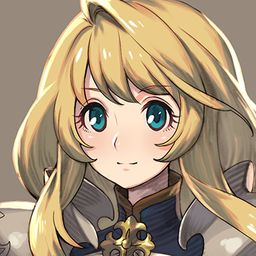

In [7]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread(files_img[201], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

### Downsample images

> Here we are going to write some downsampling code through which we are going to generate some low resolution images

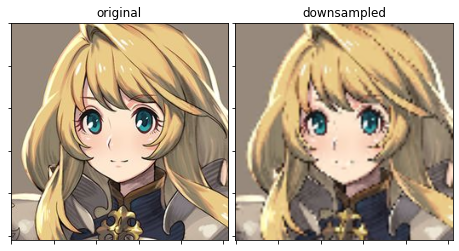

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_images(images, titles, figsize, rows=1, cols=1, axes_pad=(0.1, 0.5)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=axes_pad)

    i = 0
    for ax, img in zip(grid, images):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.minorticks_off()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        i += 1
    plt.show()

def downsample(img_file, scale=0.3):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
    img_small = cv2.resize(img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
    return img, img_small

_, img_small = downsample(files_img[201], scale=0.4)

# Lets resize the image for plotting purposes
img_small_resize = cv2.resize(img_small, (img.shape[0], img.shape[1]))

titles = ["original", "downsampled"]
images = [img, img_small_resize]
plot_images(images, titles, figsize=(10., 4.), cols=len(images))

### Lets downsample all images for training

In [9]:
dir_dataset_lr =  'dataset/another-anime-face-dataset/animefaces256cleaner_lr'
if not os.path.exists(dir_dataset_lr):
    os.makedirs(dir_dataset_lr)

for file_img in files_img:
    img, img_small = downsample(file_img, scale=0.25)
    file_img_lr = os.path.join(dir_dataset_lr, os.path.basename(file_img))
    cv2.imwrite(file_img_lr, img_small)

In [10]:
dir_dataset_lr =  'dataset/another-anime-face-dataset/animefaces256cleaner_lr'
files_img_lr = [os.path.join(dir_dataset_lr, x) for x in os.listdir(dir_dataset_lr)]
print("HR images: {}, LR images: {}".format(len(files_img), len(files_img_lr)))

HR images: 92219, LR images: 92219


## Super Resolution - Model Creation

### SR GAN

In [11]:
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add, BatchNormalization, Activation, LeakyReLU, Layer
from tensorflow.keras.models import Model

In [12]:
class SubpixelConv2D(Layer):
    """ Subpixel Conv2D Layer
    upsampling a layer from (h, w, c) to (h*r, w*r, c/(r*r)),
    where r is the scaling factor, default to 4

    # Arguments
    upsampling_factor: the scaling factor

    # Input shape
        Arbitrary. Use the keyword argument `input_shape` (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        the second and the third dimension increased by a factor of `upsampling_factor`; 
        the last layer decreased by a factor of `upsampling_factor^2`.

    # References
        Real-Time Single Image and Video Super-Resolution Using an Efficient
        Sub-Pixel Convolutional Neural Network Shi et Al. https://arxiv.org/abs/1609.05158
    """

    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space(inputs, self.upsampling_factor) # convert input from (h, w, c) to (h*r, w*r, c/(r*r)), 

    def get_config(self):
        config = {'upsampling_factor': self.upsampling_factor}
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor

        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor

        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor

        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

### Generator

In [13]:
def generator_model(input_shape):
    # w_init = tf.random_normal_initializer(stddev=0.02)

    g_init = tf.random_normal_initializer(1., 0.02)
    relu = Activation('relu')

    layer_input = Input(shape=input_shape)

    layer_past_block = Conv2D(64, (3,3), padding='SAME', activation= 'relu', kernel_initializer='HeNormal')(layer_input)
    layer_initial = layer_past_block

    # B residual blocks
    for i in range(3):

        # layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
        # layer = BatchNormalization(gamma_initializer=g_init)(layer)
        # layer = relu(layer)

        layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
        layer = BatchNormalization(gamma_initializer=g_init)(layer)

        layer = add([layer_past_block, layer])
        layer_past_block = layer

    layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer = add([layer, layer_initial])  # adding initial layer, such that model can skip entire residual blocks
    # B residual blacks end

    #layer = layer_initial # extra

    layer = Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = SubpixelConv2D(upsampling_factor=2)(layer)
    layer = relu(layer)

    layer = Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = SubpixelConv2D(upsampling_factor=2)(layer)
    layer = relu(layer)

    #layer_final = Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(layer)
    layer_final = Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'relu')(layer)

    model = Model(inputs=layer_input, outputs=layer_final, name="generator")
    return model

### Discriminator

In [14]:
# discriminator
def discriminator_model(input_shape):

    g_init= tf.random_normal_initializer(1., 0.02)

    ly_relu= LeakyReLU(alpha= 0.2)
    
    df_dim = 16

    layer_input = Input(input_shape)

    layer = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(layer_input)
    layer = ly_relu(layer)

    for i in range(2, 6):
        layer = Conv2D(df_dim*(2**i), (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(layer)
        layer = ly_relu(layer)
        layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = ly_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer_past = layer

    # Residual Block starts
    layer = Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = ly_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = BatchNormalization(gamma_initializer= g_init)(layer)

    layer = add([layer, layer_past])
    # Residual Block ends

    layer = Flatten()(layer)
    layer_final = Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(layer)
    model = Model(inputs=layer_input, outputs=layer_final, name="discriminator")

    return model

### VGG model

In [15]:
def vgg19_model(input_shape):
    vgg = tf.keras.applications.VGG19( include_top=False, weights='imagenet', 
                                       input_tensor=None, input_shape=input_shape,
                                       pooling=None, classes=1000, 
                                       classifier_activation='softmax' )

    layer_input = Input(shape=input_shape)
    layer = vgg.layers[0](layer_input)

    for layer_vgg in vgg.layers[1:17]:
        layer = layer_vgg(layer)

    model = Model(inputs=layer_input, outputs=layer, name='vgg')
    return model

### Hyperparams

In [17]:
learning_rate = 0.0002

## Adversarial learning (SRGAN)
n_epoch = 20       ## overall training epochs
n_epoch_init = 5  ## initialize generator with Epochs
batch_size = 16    ## batch size for training
steps_per_epoch = 500

# create folders to save result images and trained models
img_save_dir = "samples"
checkpoint_dir = "models"

#### Ensuring directories exist

In [18]:
if os.path.exists(img_save_dir):
    shutil.rmtree(img_save_dir)

os.makedirs(img_save_dir)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Datasets Iterator

In [19]:
dataset_lr = tf.keras.utils.image_dataset_from_directory(dir_dataset_lr, labels=None, image_size=(64, 64), batch_size=batch_size, shuffle=False)
dataset_hr = tf.keras.utils.image_dataset_from_directory(dir_dataset, labels=None, image_size=(256, 256), batch_size=batch_size, shuffle=False)
dataset =  tf.data.Dataset.zip((dataset_lr, dataset_hr))

Found 92219 files belonging to 1 classes.
Found 92219 files belonging to 1 classes.


In [106]:
# # code to verify that img_batch_lr and img_batch_hr are in sync
# i = 0
# for img_batch_lr, img_batch_hr in dataset:
#     print(img_batch_hr.shape, img_batch_lr.shape)
    
#     img_hr = img_batch_hr[0].numpy()
#     img_lr = img_batch_lr[0].numpy()

#     img_lr_resize = cv2.resize(img_lr, (img_hr.shape[0], img_hr.shape[1]))
#     cv2_imshow(np.hstack([img_hr, img_lr_resize]))

#     if i > 5:
#       break

#     i += 1

### Initialization

In [20]:
model_gen = generator_model((64, 64, 3))
model_dis = discriminator_model((256, 256, 3))
model_vgg = vgg19_model((256, 256, 3))

80150528/80134624 [==============================] - 0s 0us/step


In [21]:
g_optimizer_init = tf.optimizers.Adam(learning_rate)
g_optimizer = tf.optimizers.Adam(learning_rate)
d_optimizer = tf.optimizers.Adam(learning_rate)

### Initialize Generator

Lets give generator head start by letting it train alone for some steps

In [22]:
from PIL import Image

#g_optimizer_init = tf.optimizers.Adam(0.0002)

# Lets run generator for initial epochs
for epoch in range(n_epoch_init):
    for step, (X, Y) in enumerate(dataset):

        if step > steps_per_epoch:
            break

        with tf.GradientTape() as tape:
            Y_pred = model_gen(X)

            # Our loss function is MSE of pixel differences in actual and generated image
            mse_loss = tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, Y_pred), axis=-1))
            grad = tape.gradient(mse_loss, model_gen.trainable_weights)
            g_optimizer_init.apply_gradients(zip(grad, model_gen.trainable_weights))

        if step % 100 == 0:
            print("Epoch: [{}/{}] step, mse: {:.3f} ".format(epoch, step , mse_loss))

        if step == 0:
            img = model_gen.predict(X[0:1])[0]
            #img = Image.fromarray(np.uint8(img * 255))
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_init.png'.format(epoch)))

Epoch: [0/0] step, mse: 771744.062 
Epoch: [0/100] step, mse: 29701.543 
Epoch: [0/200] step, mse: 28347.031 
Epoch: [0/300] step, mse: 26300.791 
Epoch: [0/400] step, mse: 23194.211 
Epoch: [0/500] step, mse: 14832.969 
Epoch: [1/0] step, mse: 14047.516 
Epoch: [1/100] step, mse: 12278.125 
Epoch: [1/200] step, mse: 8015.866 
Epoch: [1/300] step, mse: 6291.344 
Epoch: [1/400] step, mse: 6310.649 
Epoch: [1/500] step, mse: 5747.188 
Epoch: [2/0] step, mse: 5389.319 
Epoch: [2/100] step, mse: 5516.667 
Epoch: [2/200] step, mse: 5182.013 
Epoch: [2/300] step, mse: 4167.546 
Epoch: [2/400] step, mse: 4632.170 
Epoch: [2/500] step, mse: 3782.893 
Epoch: [3/0] step, mse: 3540.251 
Epoch: [3/100] step, mse: 3652.689 
Epoch: [3/200] step, mse: 3846.794 
Epoch: [3/300] step, mse: 3433.254 
Epoch: [3/400] step, mse: 3902.316 
Epoch: [3/500] step, mse: 3657.981 
Epoch: [4/0] step, mse: 3419.952 
Epoch: [4/100] step, mse: 3551.749 
Epoch: [4/200] step, mse: 3752.715 
Epoch: [4/300] step, mse: 335

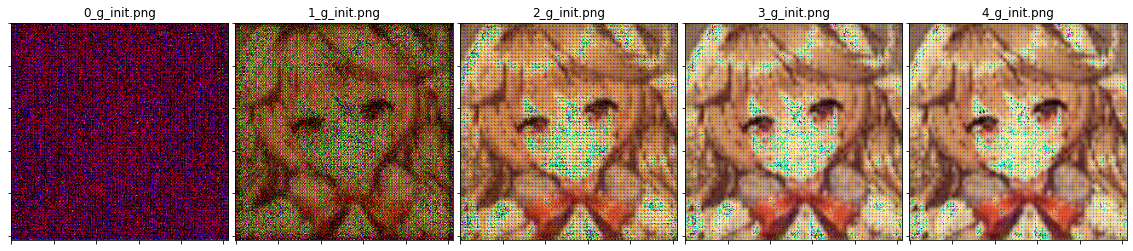

In [23]:
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir)]
sample_images_filepaths = list(filter(lambda x: not 'train' in x, sample_images_filepaths))
sample_images_filepaths.sort(key = lambda x: x.split('_')[0])

images = [cv2.imread(x) for x in sample_images_filepaths]
titles = [os.path.basename(x) for x in sample_images_filepaths]

plot_images(images, titles, figsize=(20., 8.), rows=1, cols=len(images))

In [24]:
for epoch in range(n_epoch):
    for step, (X, Y) in enumerate(dataset):    
       
        if step > steps_per_epoch:
            break

        with tf.GradientTape(persistent=True) as tape:
            fake_img = model_gen(X)
            fake_logits = model_dis(fake_img)
            real_logits = model_dis(Y)
            fake_feature = model_vgg(fake_img)
            real_feature = model_vgg(Y)

            # Discriminator. loss
            d_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.zeros_like(fake_logits)))
            d_loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits, tf.ones_like(real_logits)))
            d_loss = d_loss1 + d_loss2

            # Generator. loss
            g_gan_loss = 2e-3 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.ones_like(fake_logits)))
            mse_loss   = 2e-1 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            vgg_loss   = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1))
            g_loss = mse_loss + vgg_loss + g_gan_loss

            grad = tape.gradient(g_loss, model_gen.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, model_gen.trainable_weights))
            
            grad = tape.gradient(d_loss, model_dis.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, model_dis.trainable_weights))

        if step % 100 == 0:
            print("Epoch: [{}/{}] step: D.loss: {:.3f}: G.loss: {:.3f}".format(epoch, step , d_loss, g_loss))

        if step == 0:
            img = model_gen.predict(X[0:1])[0]
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_train.png'.format(epoch)))

Epoch: [0/0] step: D.loss: 1.006: G.loss: 673.048
Epoch: [0/100] step: D.loss: 1.006: G.loss: 625.270
Epoch: [0/200] step: D.loss: 1.006: G.loss: 624.988
Epoch: [0/300] step: D.loss: 1.006: G.loss: 557.167
Epoch: [0/400] step: D.loss: 1.006: G.loss: 629.145
Epoch: [0/500] step: D.loss: 1.006: G.loss: 588.975
Epoch: [1/0] step: D.loss: 1.006: G.loss: 550.339
Epoch: [1/100] step: D.loss: 1.006: G.loss: 570.238
Epoch: [1/200] step: D.loss: 1.006: G.loss: 601.847
Epoch: [1/300] step: D.loss: 1.006: G.loss: 538.043
Epoch: [1/400] step: D.loss: 1.006: G.loss: 613.899
Epoch: [1/500] step: D.loss: 1.006: G.loss: 576.321
Epoch: [2/0] step: D.loss: 1.006: G.loss: 538.855
Epoch: [2/100] step: D.loss: 1.006: G.loss: 564.345
Epoch: [2/200] step: D.loss: 1.006: G.loss: 484.004
Epoch: [2/300] step: D.loss: 1.006: G.loss: 431.559
Epoch: [2/400] step: D.loss: 1.006: G.loss: 483.031
Epoch: [2/500] step: D.loss: 1.006: G.loss: 449.801
Epoch: [3/0] step: D.loss: 1.006: G.loss: 422.586
Epoch: [3/100] step:

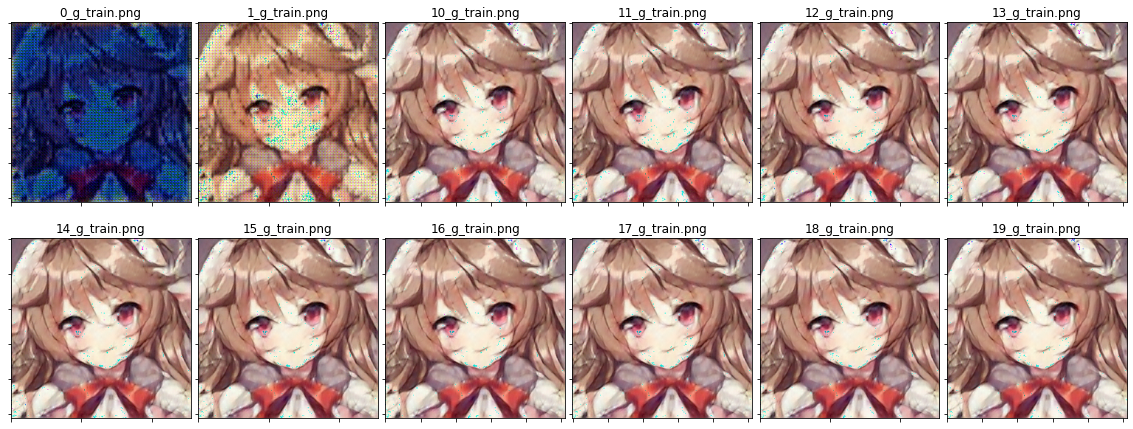

In [25]:
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir)]
sample_images_filepaths = list(filter(lambda x: 'train' in x, sample_images_filepaths))
sample_images_filepaths.sort(key = lambda x: int(x.split('_')[0]))

images = [cv2.imread(x) for x in sample_images_filepaths]
titles = [os.path.basename(x) for x in sample_images_filepaths]

plot_images(images, titles, figsize=(20., 16.), rows=4, cols=6)

## References

> https://learnopencv.com/super-resolution-in-opencv/<br>
> https://www.kaggle.com/code/akhileshdkapse/sr-super-resolution-gan-keras
